# Stacked Denoising autoencoder
Trying the reproduce the results from (http://jmlr.org/papers/volume11/vincent10a/vincent10a.pdf)
    
    Stacked Denoising Autoencoders: Learning Useful Representations in a Deep Network with a Local Denoising Criterion

The big issue for me is that I am not able to reproduce the filters the authors obtain: 
- They get blob/edge detectors
- I get some random crap

*Requirements*:
- lasagne
- nolearn

In [1]:
import numpy as np
import scipy.io
from lasagne.layers import get_output, InputLayer, DenseLayer
from lasagne.nonlinearities import rectify, leaky_rectify, tanh, linear
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet, BatchIterator, PrintLayerInfo
from nolearn.lasagne import visualize
from nolearn.lasagne import visualize
from nolearn.lasagne.visualize import plot_loss
%pylab

Using matplotlib backend: Qt4Agg
Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


## Load the data from Olshausen, create 12x12 patches
data used in section 5.1, "natural images"

In [31]:
#download the data
import urllib.request
import os
if not os.path.exists("Olshausen.mat"):
    urllib.request.urlretrieve ("http://redwood.berkeley.edu/bruno/sparsenet/IMAGES.mat", "Olshausen.mat")

In [2]:
theImages = scipy.io.loadmat('Olshausen.mat')['IMAGES']

def get_random_patch(images, patchsize=12):
    """extracts a single random patch from the 3d matrix of images with shape: (x, y, samples)"""
    q,_, N = images.shape
    r = np.random.randint(N)
    x, y =  np.random.randint(q-patchsize,  size=(2,)) # q-N to stay within the image

    return images[x:x+patchsize,y:y+patchsize, r]

patchSize= 12
sampleSize = 50000
X = np.stack([get_random_patch(theImages,patchSize) for i in range(sampleSize)], axis=0)
X_out = X.reshape((X.shape[0], -1)) # flatten to compare vs last layer

# Experiment 1: linear undercomplete coder/decoder, no noise added
section 5.1 in their paper

In [3]:
"""first experiment: a linear encoder/decoder, squared loss"""
import theano
from lasagne.init import GlorotUniform

encode_size = 50

# to get tied weights in the encoder/decoder, create this shared weightMatrix
sharedWeights = theano.shared(GlorotUniform().sample(shape=(X.shape[1]**2, encode_size))) #

layers = [
    (InputLayer, {'shape': (None, X.shape[1], X.shape[2])}),
    (DenseLayer, {'name': 'encoder', 'num_units': encode_size, 'nonlinearity': linear, 'W': sharedWeights }),
    (DenseLayer, {'name': 'decoder','num_units': patchSize**2, 'nonlinearity': linear, 'W': sharedWeights.T}),
]

ae1 = NeuralNet(
    layers=layers,
    max_epochs=100,
    update=nesterov_momentum,
    update_learning_rate=0.05,
    update_momentum=0.975,
    regression=True,
    verbose=1
)

In [4]:
ae1.fit(X, X_out);

# Neural Network with 7394 learnable parameters

## Layer information

  #  name     size
---  -------  ------
  0  input0   12x12
  1  encoder  50
  2  decoder  144

  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1       0.04156       0.02484      1.67307  0.40s
      2       0.01868       0.01506      1.24027  0.40s
      3       0.01316       0.01203      1.09476  0.40s
      4       0.01115       0.01065      1.04669  0.38s
      5       0.01016       0.00992      1.02361  0.37s
      6       0.00961       0.00952      1.00976  0.38s
      7       0.00931       0.00929      1.00160  0.39s
      8       0.00913       0.00916      0.99680  0.39s
      9       0.00903       0.00908      0.99397  0.39s
     10       0.00896       0.00903      0.99222  0.38s
     11       0.00892       0.00900      0.99106  0.38s
     12       0.00890       0.00898      0.99024  0.39s
     13       0.00888       0.00897      0.98963  0

(0.008, 0.01)

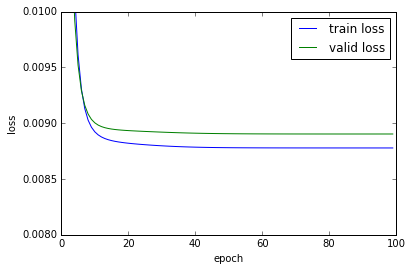

In [7]:
plot_loss(ae1)
plt.ylim([0.008, 0.010])

## inspect the reconstruction

In [6]:
from plottingUtils import tile_raster_images
%matplotlib inline

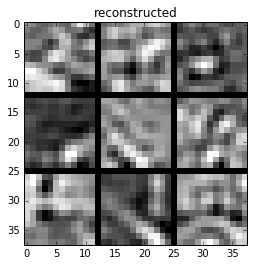

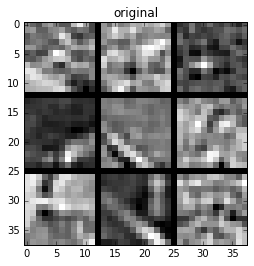

In [9]:
X_pred = ae1.predict(X)
tile_raster_images(X_pred[0:9,:], (patchSize,patchSize), (3,3), tile_spacing=(1,1))
title('reconstructed')
tile_raster_images(X_out[0:9,:], (patchSize,patchSize), (3,3), tile_spacing=(1,1));
title('original');

## inspect the learned filters

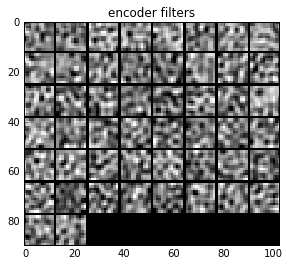

In [10]:
W_encode = ae1.layers_['encoder'].W.get_value()
tile_raster_images(W_encode.T, (patchSize,patchSize), (7,8), tile_spacing=(1,1)); title('encoder filters')

doesnt really look like the "blob detectors" in Figure 5 middle

# Experiment 2: overcomplete AE with Gaussian noise
actually, we're supposed to add Gaussian noise each epoch, but thats kind of complicated right now.

Hence, I corrupt the images once in the beginning

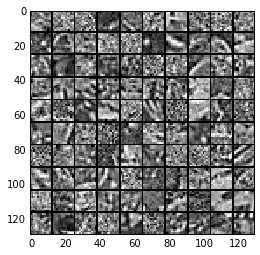

In [18]:
#corrupt the data with gaussian noise
sigma = 0.1
X_corrupted = X + np.random.normal(0,sigma, X.shape)
tile_raster_images(X_corrupted[0:100,:], (patchSize,patchSize), (10,10), tile_spacing=(1,1));

In [19]:
encode_size = 200

#again, tied weights in the en/decoder
sharedWeights2 = theano.shared(GlorotUniform().sample(shape=(X.shape[1]**2, encode_size))) #
layers2 = [
    (InputLayer, {'shape': (None, X.shape[1], X.shape[2])}),
    (DenseLayer, {'name': 'encoder', 'num_units': encode_size, 'nonlinearity': linear, 'W': sharedWeights2 }),
    (DenseLayer, {'name': 'decoder','num_units': patchSize**2, 'nonlinearity': linear, 'W': sharedWeights2.T}),
]

ae2 = NeuralNet(
    layers=layers2,
    max_epochs=100,
    update=nesterov_momentum,
    update_learning_rate=0.01,
    update_momentum=0.975,
    regression=True,
    verbose=1
)

In [20]:
ae2.fit(X_corrupted, X_out);

# Neural Network with 29144 learnable parameters

## Layer information

  #  name     size
---  -------  ------
  0  input0   12x12
  1  encoder  200
  2  decoder  144

  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1       0.04695       0.02384      1.96906  0.92s
      2       0.01813       0.01452      1.24870  1.10s
      3       0.01251       0.01115      1.12227  1.13s
      4       0.01018       0.00952      1.06983  0.96s
      5       0.00896       0.00858      1.04429  1.30s
      6       0.00822       0.00798      1.03008  1.00s
      7       0.00772       0.00756      1.02135  1.20s
      8       0.00736       0.00725      1.01561  1.10s
      9       0.00710       0.00702      1.01161  0.99s
     10       0.00690       0.00684      1.00872  1.03s
     11       0.00673       0.00669      1.00657  0.96s
     12       0.00661       0.00657      1.00492  1.52s
     13       0.00650       0.00648      1.00362 

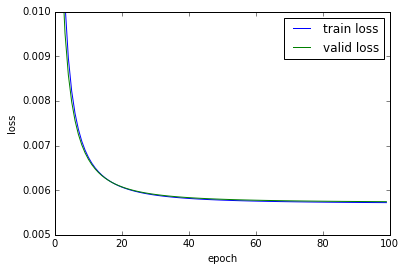

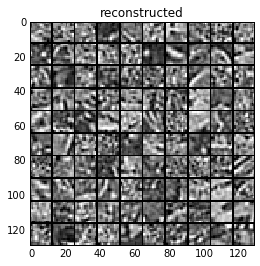

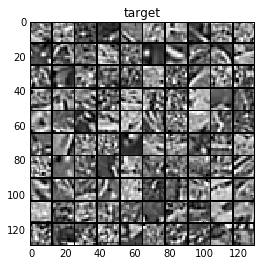

In [23]:
plot_loss(ae2);ylim([0.005,0.01])

# predictions
X_pred = ae2.predict(X_corrupted)
tile_raster_images(X_pred[0:100,:], (patchSize,patchSize), (10,10), tile_spacing=(1,1)); title('reconstructed')
tile_raster_images(X_out[0:100,:], (patchSize,patchSize), (10,10), tile_spacing=(1,1)); title('target')

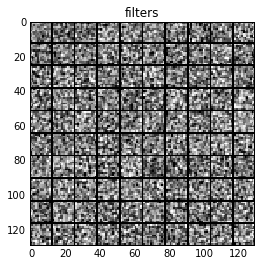

In [24]:
#filters
W_encode = ae2.layers_['encoder'].W.get_value()
tile_raster_images(W_encode.T, (patchSize,patchSize), (10,10), tile_spacing=(1,1)); title('filters');

In [ ]:
VERY different from the edge detectors in Figre 6